In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
import os

# Cheminformatics stack
import rdkit
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import AllChem
from rdkit.Chem import FragmentMatcher
from rdkit.Chem import rdFMCS
from glob import glob
from rdkit import Chem
from rdkit.Chem import Draw
# For segfault
import faulthandler
import signal
from subprocess import Popen, PIPE


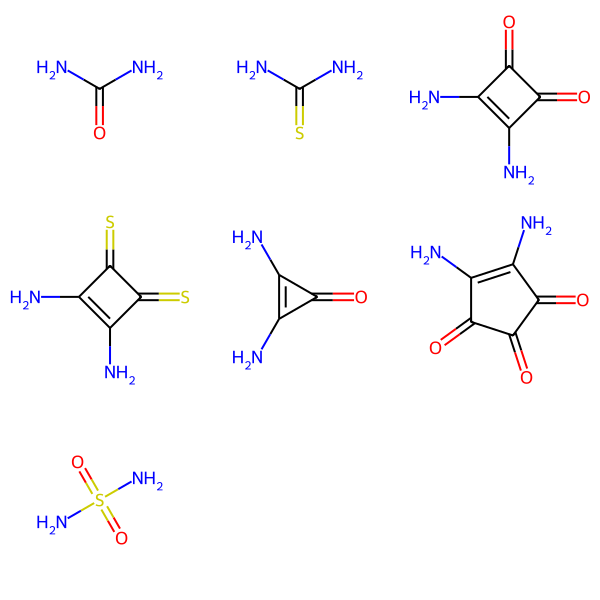

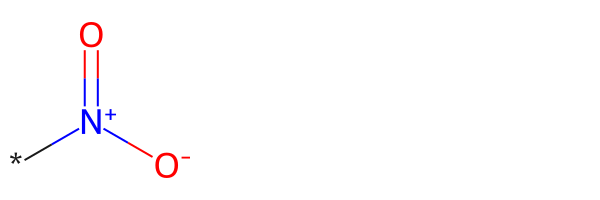

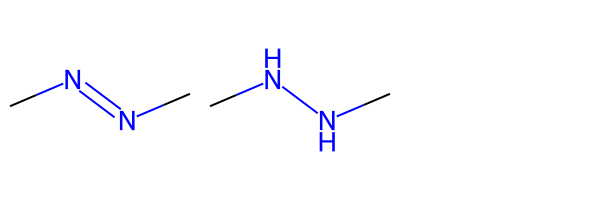

In [3]:
# Classification rules

patterns_catalytic = [
    "NC(N)=O",
    "NC(N)=S",
    "O=C1C(N)=C(N)C1=O",
    "S=C1C(N)=C(N)C1=S",
    "O=C1C(N)=C1N",
    "O=C(C(N)=C(N)C1=O)C1=O",
    "O=S(N)(N)=O",
]
patterns_inhibitor = [
    "*[N+]([O-])=O",
    #"*C(=O)",
]
patterns_photoactive = [
    "CN=NC",
    "CNNC",
]


# draw mol patterns
mol_patterns = np.array([Chem.MolFromSmiles(smi) for smi in patterns_catalytic], dtype=object)
img = Draw.MolsToGridImage(mol_patterns, molsPerRow=3)
display(img)
mol_patterns = np.array([Chem.MolFromSmiles(smi) for smi in patterns_inhibitor], dtype=object)
img = Draw.MolsToGridImage(mol_patterns, molsPerRow=3)
display(img)
mol_patterns = np.array([Chem.MolFromSmiles(smi) for smi in patterns_photoactive], dtype=object)
display(Draw.MolsToGridImage(mol_patterns, molsPerRow=3))

In [4]:
def initialise_matchers(patterns):
    """Initialise fragment matchers for a list of patterns.

    Args:
    patterns: list of SMILES patterns

    Returns:
    pmatchers: list of FragmentMatcher objects
    """
    pmatchers = [FragmentMatcher.FragmentMatcher() for p in patterns]
    for p, pm in zip(patterns, pmatchers):
        pm.Init(p)
    return pmatchers


In [11]:
mols

 None,

In [14]:
df_psw = pd.read_csv("data/PSW_database.txt", sep="\t")
mols = [Chem.MolFromSmiles(smi) for smi in df_psw["Smiles"]]
df_psw["Mol"] = mols
df_psw.dropna(subset=["Mol"], inplace=True)
mols = df_psw["Mol"]

[11:17:58] Explicit valence for atom # 7 B, 4, is greater than permitted


In [19]:
from rdkit.Chem import rdMMPA
def fragment_mols_to_3_parts(mols_list,patterns_photoactive,pattern_Inhibitor,patterns_catalytic):
    """
    This function takes a list of molecules and fragments them into 3 parts: left block, linker and right block.
    The function returns 3 dataframes, one for each part.
    Parameters:
    mols_list: list of RDKit molecules
    """
    pmatchers_photoactive = initialise_matchers(patterns_photoactive)
    pmatchers_inhibitor = initialise_matchers(pattern_Inhibitor)
    pmatchers_catalytic = initialise_matchers(patterns_catalytic)
    linker_list = []
    catalist_block_list = []
    inhibitor_block_list = []
    for mols in mols_list:
        frag3 = rdMMPA.FragmentMol(mols)

        for frag in frag3:
            if frag[0] is not None:
                frag_smiles_ = Chem.MolToSmiles(frag[1]).split('.')
                if len(frag_smiles_) == 2 and any([pm.HasMatch(frag[0]) for pm in pmatchers_photoactive]):
                        right_block = Chem.MolFromSmiles(frag_smiles_[1])
                        left_block = Chem.MolFromSmiles(frag_smiles_[0])
                        if any([pm.HasMatch(right_block) for pm in pmatchers_catalytic]) and any([pm.HasMatch(left_block) for pm in pmatchers_inhibitor]):
                            linker_list.append(frag[0])
                            catalist_block_list.append(right_block)
                            inhibitor_block_list.append(left_block)
                        if any([pm.HasMatch(left_block) for pm in pmatchers_catalytic]) and any([pm.HasMatch(right_block) for pm in pmatchers_inhibitor]):
                            linker_list.append(frag[0])
                            catalist_block_list.append(left_block)
                            inhibitor_block_list.append(right_block)

    print(' number of linkers:', len(linker_list))  
    print(' number of inhibitor blocks:', len(inhibitor_block_list))
    print(' number of catalutic blocks:', len(catalist_block_list))
    df_linkers= pd.DataFrame({'linker':linker_list, 'smiles': [Chem.MolToSmiles(m) for m in linker_list]})
    df_linkers.drop_duplicates(subset=['smiles'],inplace=True) 
    print(' number of unique linkers:', df_linkers.shape[0])
    df_linkers.head()
    df_inhibitor_block = pd.DataFrame({'right_block':inhibitor_block_list, 'smiles': [Chem.MolToSmiles(m) for m in inhibitor_block_list],'linkers_smiles': [Chem.MolToSmiles(m) for m in linker_list]})
    print(' number of unique right blocks:', df_inhibitor_block.shape[0])
    df_catalytic_block = pd.DataFrame({'left_block':catalist_block_list, 'smiles': [Chem.MolToSmiles(m) for m in catalist_block_list],'linkers_smiles': [Chem.MolToSmiles(m) for m in linker_list]})
    print(' number of unique left blocks:', df_catalytic_block.shape[0])
    return df_linkers, df_inhibitor_block, df_catalytic_block

df_linkers, df_left_block, df_right_block = fragment_mols_to_3_parts(mols,patterns_photoactive,patterns_inhibitor,patterns_catalytic)
print('Linkers')
display(Draw.MolsToGridImage(df_linkers['linker'][:10]))
print('Right blocks')
display(Draw.MolsToGridImage(df_right_block['right_block'][:10]))
print('Left blocks')
display(Draw.MolsToGridImage(df_left_block['left_block'][:10]))


 number of linkers: 0
 number of inhibitor blocks: 0
 number of catalutic blocks: 0
 number of unique linkers: 0
 number of unique right blocks: 22
 number of unique left blocks: 22
Linkers


[11:26:55] 

****
Pre-condition Violation
no draw context
Violation occurred on line 211 in file /project/build/temp.linux-x86_64-cpython-38/rdkit/Code/GraphMol/MolDraw2D/MolDraw2DCairo.cpp
Failed Expression: dp_cr
----------
Stacktrace:
----------
****



RuntimeError: Pre-condition Violation
	no draw context
	Violation occurred on line 211 in file Code/GraphMol/MolDraw2D/MolDraw2DCairo.cpp
	Failed Expression: dp_cr
	RDKIT: 2024.03.5
	BOOST: 1_85
